In [1]:
#pip install matplotlib

# Лабораторная работа № 4

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (train_test_split)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn import linear_model
%matplotlib inline

In [26]:
# исходные данные
df_name = r'auto-mpg.data.txt'
# видоизмененный датасет
new_df_name = r'df.txt'
# заголовок, который будет добавлен в новый датасет
header = 'mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name\n'

with open(df_name, 'r', newline='') as read_file, \
         open(new_df_name, 'w', newline='') as write_file:
    list_lines = read_file.readlines()
    # пробежимся по строкам в исходном файле
    for i, line in enumerate(list_lines):
        # заменим знаки табуляции на запятые
        list_lines[i] = line.replace('\t', ',')
        # заменим подряд идущие пробелы на запятые
        max_spaces = 7
        for spaces_number in reversed(range(2, max_spaces)):
            spaces = ' '*spaces_number
            list_lines[i] = list_lines[i].replace(spaces, ',')
        list_lines[i] = list_lines[i].replace('?', '0')
        list_lines[i] = list_lines[i].replace(',,', ',')
    # запишем полученные строки и заголовок в новый файл
    write_file.write(header)
    write_file.writelines(list_lines)

# 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
### Данные описывают потребление топлива в милях на галон (mpg) у разных автомобилей, что должно быть предсказано с точки зрения 3-х многозначных дискретных и 5-и вещественных атрибутов.

In [27]:
tabledata = [["mpg", "потребление топлива", "вещественный"],
             ["cylinders", "число цилиндров", "дискретный"],
             ["displacment", "литраж", "вещественный"],
             ["horsepower", "мощность", "вещественный"],
             ["weight", "вес", "вещественный"],
             ["acceleration", "ускорение", "вещественный"],
             ["model year", "год выпуска", "дискретный"], 
             ["origin", "место производства", "дискретный"],
             ["car name", "название модели", "строка(уникальная)"]]
tabledata
pd.DataFrame(tabledata, columns=["Переменная","Описание", "Параметры"])

,Переменная,Описание,Параметры
0,mpg,потребление топлива,вещественный
1,cylinders,число цилиндров,дискретный
2,displacment,литраж,вещественный
3,horsepower,мощность,вещественный
4,weight,вес,вещественный
5,acceleration,ускорение,вещественный
6,model year,год выпуска,дискретный
7,origin,место производства,дискретный
8,car name,название модели,строка(уникальная)


Можем смело убрать столбец car name из датасета, так как он не пригодится при решении задачи регрессии

Исходный датасет был представлен в таком виде, что его пришлось видоизменить для возможности считытвания

In [28]:
df = pd.read_csv(new_df_name, sep=',')
df.drop('car name', axis=1, inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [29]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (398, 8)


mpg             398
cylinders       398
displacement    398
horsepower      398
weight          398
acceleration    398
model year      398
origin          398
dtype: int64

# 2) Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [30]:
print("До:", df.shape)
df = df.drop_duplicates()
print("После:", df.shape)

До: (398, 8)
После: (398, 8)


# 3) Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования

In [31]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
categorial:  []


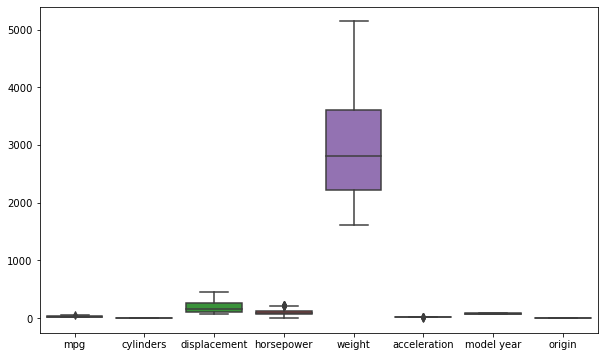

In [32]:

plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

Место производства обозначено через ключи, поэтому оно должно относится к категориальным признакам. Количество цилиндров имеет несколько типов, промежуточные значения не допускаются. Преобразуем эти столбцы к строковому виду

In [33]:
df['cylinders'] = df['cylinders'].apply(lambda x: str(x))
df['origin'] = df['origin'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
categorial:  ['cylinders', 'origin']


В качестве способа масштабирования выберем метод нормализации

In [34]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0.239362,8,0.617571,0.565217,0.536150,0.238095,0.0,1
1,0.159574,8,0.728682,0.717391,0.589736,0.208333,0.0,1
2,0.239362,8,0.645995,0.652174,0.516870,0.178571,0.0,1
3,0.186170,8,0.609819,0.652174,0.516019,0.238095,0.0,1
4,0.212766,8,0.604651,0.608696,0.520556,0.148810,0.0,1


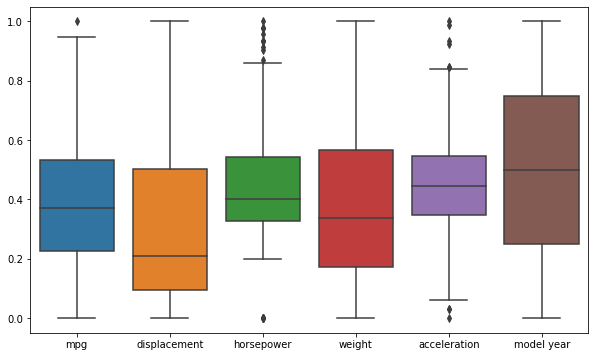

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

# 4) Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [36]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

cylinders :  ['8' '4' '6' '3' '5']
origin :  ['1' '3' '2']


Уникальных значений оказалось не много, поэтмому можно применить dummy-кодирование

In [37]:
df_categorial = pd.get_dummies(df[categorial_columns])
df.drop(categorial_columns, axis=1, inplace=True)
df = pd.concat([df_categorial, df] , axis=1)

print(df.shape)
df.head()

(398, 14)


,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,mpg,displacement,horsepower,weight,acceleration,model year
0,0,0,0,0,1,1,0,0,0.239362,0.617571,0.565217,0.536150,0.238095,0.0
1,0,0,0,0,1,1,0,0,0.159574,0.728682,0.717391,0.589736,0.208333,0.0
2,0,0,0,0,1,1,0,0,0.239362,0.645995,0.652174,0.516870,0.178571,0.0
3,0,0,0,0,1,1,0,0,0.186170,0.609819,0.652174,0.516019,0.238095,0.0
4,0,0,0,0,1,1,0,0,0.212766,0.604651,0.608696,0.520556,0.148810,0.0


# 5) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

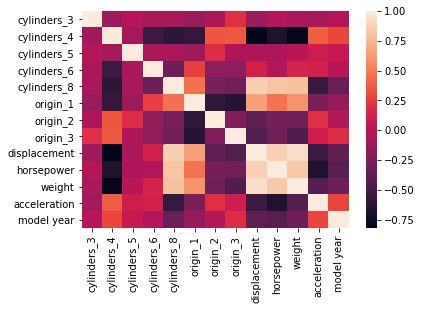

In [38]:
df_corr = df.drop('mpg', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [39]:
df_corr

,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,displacement,horsepower,weight,acceleration,model year
cylinders_3,1.000000,-0.103323,-0.008781,-0.052114,-0.059537,-0.130253,-0.046547,0.202471,-0.117001,-0.008464,-0.068134,-0.084803,-0.013916
cylinders_4,-0.103323,1.000000,-0.089367,-0.530382,-0.605929,-0.577788,0.358080,0.359268,-0.823494,-0.676761,-0.802992,0.384747,0.295302
cylinders_5,-0.008781,-0.089367,1.000000,-0.045075,-0.051496,-0.112660,0.188647,-0.043369,-0.040525,-0.043681,0.013695,0.096990,0.070558
cylinders_6,-0.052114,-0.530382,-0.045075,1.000000,-0.305620,0.272871,-0.174247,-0.164767,0.122760,-0.030082,0.139308,0.130516,-0.011412
cylinders_8,-0.059537,-0.605929,-0.051496,-0.305620,1.000000,0.457089,-0.272973,-0.294053,0.860098,0.810944,0.799446,-0.560540,-0.337150
origin_1,-0.130253,-0.577788,-0.112660,0.272871,0.457089,1.000000,-0.597198,-0.643317,0.651407,0.461694,0.598398,-0.250806,-0.139883
origin_2,-0.046547,0.358080,0.188647,-0.174247,-0.272973,-0.597198,1.000000,-0.229895,-0.373886,-0.277993,-0.298843,0.204473,-0.024489
origin_3,0.202471,0.359268,-0.043369,-0.164767,-0.294053,-0.643317,-0.229895,1.000000,-0.433505,-0.294848,-0.440817,0.109144,0.193101
displacement,-0.117001,-0.823494,-0.040525,0.122760,0.860098,0.651407,-0.373886,-0.433505,1.000000,0.869448,0.932824,-0.543684,-0.370164
horsepower,-0.008464,-0.676761,-0.043681,-0.030082,0.810944,0.461694,-0.277993,-0.294848,0.869448,1.000000,0.835399,-0.667295,-0.398690


По диаграмме видно, что литраж сильно коррелирует с мощностью, весом, и ускорением. Поэтому удалим этот параметр из датасета

In [40]:
df.drop('displacement', axis=1, inplace=True)

# 6) Заполните пропущенные значения в данных

In [41]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (398, 13)


cylinders_3     398
cylinders_4     398
cylinders_5     398
cylinders_6     398
cylinders_8     398
origin_1        398
origin_2        398
origin_3        398
mpg             398
horsepower      398
weight          398
acceleration    398
model year      398
dtype: int64

# 7) Решите поставленную задачу регрессии в соответствии с заданием
1. Линейная регрессия без использования регуляризаторов
2. Линейная регрессия, RIDGE регуляризатор

In [42]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('mpg', axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Линейная регрессия без использования регуляризаторов

In [43]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

198    0.010140
396    0.055228
33    -0.000332
208    0.112367
93    -0.013838
84     0.031042
373    0.114736
94    -0.094664
222    0.039187
126    0.012882
9     -0.071684
383   -0.042761
56     0.002950
72    -0.015043
132   -0.011469
Name: mpg, dtype: float64


In [44]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.9312129795147518
spearmen correlation:  0.9491016889307253


Линейная регрессия, RIDGE регуляризатор

In [45]:
import warnings
warnings.filterwarnings("ignore")

regr = linear_model.Ridge()
params = {'alpha': np.arange(0, 3, 0.05)}
regr_grid = GridSearchCV(regr, params)
regr_grid.fit(X_train, y_train)
best_alpha = regr_grid.best_estimator_.alpha
print('best alpha:', best_alpha)

best alpha: 0.15000000000000002


In [46]:
regr = linear_model.Ridge(alpha=best_alpha)
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

198   -0.001067
396    0.052279
33    -0.002244
208    0.115824
93    -0.009621
84     0.019935
373    0.113643
94    -0.087561
222    0.042191
126    0.017001
9     -0.071016
383   -0.050506
56    -0.009045
72    -0.011953
132   -0.018032
Name: mpg, dtype: float64


In [47]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.9309508341180982
spearmen correlation:  0.9502423990896824
